<a href="https://colab.research.google.com/github/sebasesto/CEIA/blob/master/NLP/Sesto_4d_predicci%C3%B3n_palabra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [7]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding


### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [8]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('simpsons_dataset.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1VLVgb3fD02XrF2V5OruKvQTOT91juXcs&export=download'
        output = 'songs_dataset.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [9]:
# Posibles bandas
os.listdir("./songs_dataset/")

['notorious_big.txt',
 'drake.txt',
 'bob-marley.txt',
 'michael-jackson.txt',
 'bruce-springsteen.txt',
 'bruno-mars.txt',
 'alicia-keys.txt',
 'bob-dylan.txt',
 'amy-winehouse.txt',
 'Lil_Wayne.txt',
 'dr-seuss.txt',
 'dj-khaled.txt',
 'britney-spears.txt',
 'al-green.txt',
 'bjork.txt',
 'nursery_rhymes.txt',
 'ludacris.txt',
 'johnny-cash.txt',
 'notorious-big.txt',
 'nicki-minaj.txt',
 'cake.txt',
 'beatles.txt',
 'r-kelly.txt',
 'lin-manuel-miranda.txt',
 'nirvana.txt',
 'janisjoplin.txt',
 'rihanna.txt',
 'lorde.txt',
 'dickinson.txt',
 'adele.txt',
 'paul-simon.txt',
 'patti-smith.txt',
 'radiohead.txt',
 'leonard-cohen.txt',
 'jimi-hendrix.txt',
 'disney.txt',
 'nickelback.txt',
 'missy-elliott.txt',
 'blink-182.txt',
 'Kanye_West.txt',
 'lil-wayne.txt',
 'kanye.txt',
 'eminem.txt',
 'bieber.txt',
 'kanye-west.txt',
 'joni-mitchell.txt',
 'lady-gaga.txt',
 'prince.txt',
 'dolly-parton.txt']

In [10]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/disney.txt', sep='/n', header=None)
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0
0,When somebody loved me
1,Everything was beautiful
2,Every hour we spent together
3,Lives within my heart And when she was sad
4,I was there to dry her tears
5,And when she was happy so was I
6,When she loved me Through the summer and the fall
7,We had each other that was all
8,Just she and I together
9,Like it was meant to be And when she was lonely


In [11]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2499


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [34]:
# largo de la secuencia, incluye seq input + word output
train_len = 4
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[3,0]
text

'Lives within my heart And when she was sad'

In [35]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['lives', 'within', 'my', 'heart', 'and', 'when', 'she', 'was', 'sad']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [36]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [37]:
# Demos un vistazo
sentence_tokens[:5]

[['when', 'somebody', 'loved', 'me'],
 ['everything', 'was', 'beautiful'],
 ['every', 'hour', 'we', 'spent', 'together'],
 ['lives', 'within', 'my', 'heart', 'and', 'when', 'she', 'was', 'sad'],
 ['i', 'was', 'there', 'to', 'dry', 'her', 'tears']]

In [39]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
print(train_len)
print(len(tokens))

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)


4
9


In [40]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['lives', 'within', 'my', 'heart'],
 ['within', 'my', 'heart', 'and'],
 ['my', 'heart', 'and', 'when'],
 ['heart', 'and', 'when', 'she'],
 ['and', 'when', 'she', 'was']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [41]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [42]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[7, 5, 3, 1], [5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 6], [2, 4, 6, 8]]

In [43]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

5


In [44]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

8


In [45]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'heart': 1, 'and': 2, 'my': 3, 'when': 4, 'within': 5, 'she': 6, 'lives': 7, 'was': 8}


In [46]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'my': 3, 'heart': 4, 'lives': 1, 'within': 2, 'and': 4, 'when': 3, 'she': 2, 'was': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [47]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                                When somebody loved me
1                              Everything was beautiful
2                          Every hour we spent together
3            Lives within my heart And when she was sad
4                          I was there to dry her tears
5                       And when she was happy so was I
6     When she loved me Through the summer and the fall
7                        We had each other that was all
8                               Just she and I together
9       Like it was meant to be And when she was lonely
10                           I was there to comfort her
11    And I knew that she loved me So the years went by
12                                    I stayed the same
13                              She began to drift away
14          I was left alone Still I waited for the day
15                                       When she'd say
Name: 0, dtype: object

In [48]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'When somebody loved me Everything was beautiful Every hour we spent together Lives within my heart And when she was sad I was there to dry her tears And when she was happy so was I When she loved me Through the summer and the fall We had each other that was all Just she and I together Like it was meant to be And when she was lonely I was there to comfort her And I knew that she loved me So the years went by I stayed the same She began to drift away I was left alone Still I waited for the day When she\'d say I will always love you Lonely and forgotten Never thought she\'d look my way She smiled at me and held me Just like she used to do Like she loved me When she loved me When somebody loved me Everything was beautiful Every hour we spent together Lives within my heart When she loved me, hey Sentimentos são Fáceis de mudar Mesmo entre quem Não vê que alguém Pode ser seu par Basta um olhar Que o outro não espera Para assustar e até perturbar Mesmo a bela e a fera Sentimento assim Sempre

In [49]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['when',
 'somebody',
 'loved',
 'me',
 'everything',
 'was',
 'beautiful',
 'every',
 'hour',
 'we',
 'spent',
 'together',
 'lives',
 'within',
 'my',
 'heart',
 'and',
 'when',
 'she',
 'was']

In [50]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 17542


In [51]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [52]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['when', 'somebody', 'loved', 'me'],
 ['somebody', 'loved', 'me', 'everything'],
 ['loved', 'me', 'everything', 'was'],
 ['me', 'everything', 'was', 'beautiful'],
 ['everything', 'was', 'beautiful', 'every'],
 ['was', 'beautiful', 'every', 'hour'],
 ['beautiful', 'every', 'hour', 'we'],
 ['every', 'hour', 'we', 'spent'],
 ['hour', 'we', 'spent', 'together'],
 ['we', 'spent', 'together', 'lives'],
 ['spent', 'together', 'lives', 'within'],
 ['together', 'lives', 'within', 'my'],
 ['lives', 'within', 'my', 'heart'],
 ['within', 'my', 'heart', 'and'],
 ['my', 'heart', 'and', 'when'],
 ['heart', 'and', 'when', 'she'],
 ['and', 'when', 'she', 'was'],
 ['when', 'she', 'was', 'sad'],
 ['she', 'was', 'sad', 'i'],
 ['was', 'sad', 'i', 'was']]

In [53]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[30, 346, 137, 8],
 [346, 137, 8, 138],
 [137, 8, 138, 61],
 [8, 138, 61, 206],
 [138, 61, 206, 95],
 [61, 206, 95, 536],
 [206, 95, 536, 18],
 [95, 536, 18, 537],
 [536, 18, 537, 165],
 [18, 537, 165, 460],
 [537, 165, 460, 403],
 [165, 460, 403, 16],
 [460, 403, 16, 63],
 [403, 16, 63, 4],
 [16, 63, 4, 30],
 [63, 4, 30, 58],
 [4, 30, 58, 61],
 [30, 58, 61, 404],
 [58, 61, 404, 5],
 [61, 404, 5, 61]]

In [54]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 17538


### 3 - Input y target

In [55]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [58]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:\n", ex)
print("Todos los elementos menos el último:\n", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos:
 [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último:
 [[1 2 3]
 [5 6 7]]


In [59]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:\n", input)
print("Target:", target)

Input:
 [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [60]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(17538, 3)
(17538,)


In [61]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'a',
 3: 'you',
 4: 'and',
 5: 'i',
 6: 'to',
 7: 'of',
 8: 'me',
 9: 'it',
 10: 'be',
 11: 'on',
 12: "it's",
 13: 'in',
 14: 'that',
 15: 'is',
 16: 'my',
 17: 'your',
 18: 'we',
 19: 'can',
 20: 'all',
 21: 'just',
 22: 'for',
 23: 'know',
 24: 'as',
 25: 'with',
 26: 'but',
 27: 'no',
 28: 'so',
 29: 'what',
 30: 'when',
 31: 'this',
 32: 'like',
 33: 'world',
 34: 'one',
 35: 'got',
 36: "i'm",
 37: 'there',
 38: 'are',
 39: 'if',
 40: 'come',
 41: 'love',
 42: 'never',
 43: 'la',
 44: 'will',
 45: 'now',
 46: 'do',
 47: 'small',
 48: 'have',
 49: "you're",
 50: 'they',
 51: 'see',
 52: "don't",
 53: 'go',
 54: 'at',
 55: 'time',
 56: 'where',
 57: 'up',
 58: 'she',
 59: 'our',
 60: 'oh',
 61: 'was',
 62: 'her',
 63: 'heart',
 64: 'who',
 65: 'from',
 66: 'here',
 67: 'look',
 68: 'way',
 69: 'how',
 70: 'let',
 71: 'make',
 72: 'out',
 73: 'sea',
 74: "you'll",
 75: "i'll",
 76: "i've",
 77: 'little',
 78: 'eye',
 79: 'day',
 80: 'man',
 81: 'say',
 82: 'girl',
 83

In [62]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2552

In [63]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [64]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [65]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(17538, 2552)

### 4 - Entrenar el modelo

In [66]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [67]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2552

In [68]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 5)              12765     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 64)             17920     
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 2552)              84216     
Total params: 150,005
Trainable params: 150,005
Non-trainable params: 0
__________________________________________________

In [69]:
hist = model.fit(x_data, y_data, epochs=200, validation_split=0.2)

Epoch 1/200
439/439 [==============================] - 13s 12ms/step - loss: 6.6281 - accuracy: 0.0411 - val_loss: 6.5846 - val_accuracy: 0.0436
Epoch 2/200
439/439 [==============================] - 5s 10ms/step - loss: 6.2486 - accuracy: 0.0435 - val_loss: 6.7457 - val_accuracy: 0.0436
Epoch 3/200
439/439 [==============================] - 4s 10ms/step - loss: 6.1961 - accuracy: 0.0448 - val_loss: 6.7744 - val_accuracy: 0.0436
Epoch 4/200
439/439 [==============================] - 4s 10ms/step - loss: 6.1658 - accuracy: 0.0449 - val_loss: 6.9478 - val_accuracy: 0.0436
Epoch 5/200
439/439 [==============================] - 4s 10ms/step - loss: 6.1235 - accuracy: 0.0449 - val_loss: 7.0059 - val_accuracy: 0.0436
Epoch 6/200
439/439 [==============================] - 4s 10ms/step - loss: 6.0843 - accuracy: 0.0440 - val_loss: 7.0483 - val_accuracy: 0.0433
Epoch 7/200
439/439 [==============================] - 4s 10ms/step - loss: 6.0291 - accuracy: 0.0451 - val_loss: 7.0134 - val_accuracy

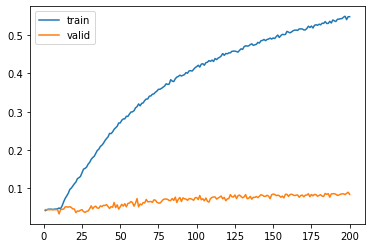

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Conclusion:
Lamentablemente no se obtiene un buen entrenamiento y cuando se hace la validación es aun peor,esto puede deberse al ser un dataset muy chico.

### 5 - Predicción de próxima palabra

In [71]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [72]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 3.6 MB 11.2 MB/s 
     |████████████████████████████████| 206 kB 57.2 MB/s 
     |████████████████████████████████| 1.9 MB 32.1 MB/s 
     |████████████████████████████████| 3.5 MB 44.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 961 kB 39.3 MB/s 


In [73]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://31281.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

Conclusion:
Ante el ingreso de "Every road leads" la salida "long" tiene sentido gramatical, este ejemplo se sacó del dataset donde estaba el documento "Every road leads back to the place I know"

### 6 - Generación de secuencias nuevas

In [74]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [83]:
# Lives within my heart And when she was sad
input_text='Lives within my heart And'
generate_seq(model, tok, input_text, max_length=3, n_words=2)

'Lives within my heart And the jolly'

In [85]:
# If the wind in my sail on the sea stays behind me
input_text='If the wind'
generate_seq(model, tok, input_text, max_length=3, n_words=3)

"If the wind it's no shimmering"

Si bien el desempeño es pobre, gramaticalmente tiene sentido aunque el viento no brille jajaja, pero esto se debe al ser un dataset de solo 17538 documentos con 2552 tokens, admás existen palabras en portugues dentro del dataset lo que complica su funcionamiento, se probo con 20 epochs y luego con 200 pero su resultado fue aproximadamente el mismo y hubo overfitting.

Se debería limpiar el dataset del portugues para evaluar nuevamente o utilizar otro mas grande.

Además es recomendable complejizar la red neuronal.


### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.